In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install --upgrade tensorflow

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Adagrad
from keras.layers import Dropout
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Veri setinin yolu
data_dir = "/content/drive/MyDrive/proje/cicekler"

# Veri setini train, test ve validation olarak ayırma oranları
train_split = 0.7
val_split = 0.15
test_split = 0.15

datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)

# Train veri seti ayrıma
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation veri seti ayırma
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test veri seti ayırma
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2550 images belonging to 6 classes.
Found 449 images belonging to 6 classes.
Found 449 images belonging to 6 classes.


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 989s 12s/step - accuracy: 0.2484 - loss: 1.7716 - val_accuracy: 0.6258 - val_loss: 1.3164
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 513ms/step - accuracy: 0.5688 - loss: 1.3864 - val_accuracy: 0.8241 - val_loss: 0.9708
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 497ms/step - accuracy: 0.7463 - loss: 1.0790 - val_accuracy: 0.8797 - val_loss: 0.7588
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 497ms/step - accuracy: 0.8352 - loss: 0.8326 - val_accuracy: 0.9042 - val_loss: 0.6306
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 500ms/step - accuracy: 0.8775 - loss: 0.6573 - val_accuracy: 0.9065 - val_loss: 0.5430
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 500ms/step - accuracy: 0.8981 - loss: 0.5368 - val_accuracy: 0.9109 - val_loss: 0.4760
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - accuracy: 0.9220 - loss: 0.4487 - val_accuracy: 0.9176 - val_loss: 0.4189
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 499ms/step - accuracy: 0.9215 - loss: 0.3964 - val_accur

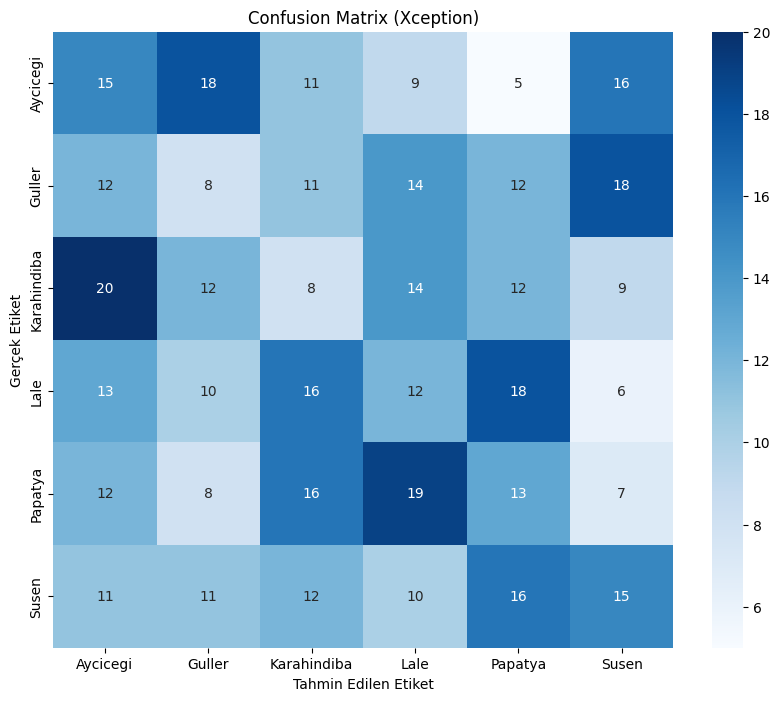

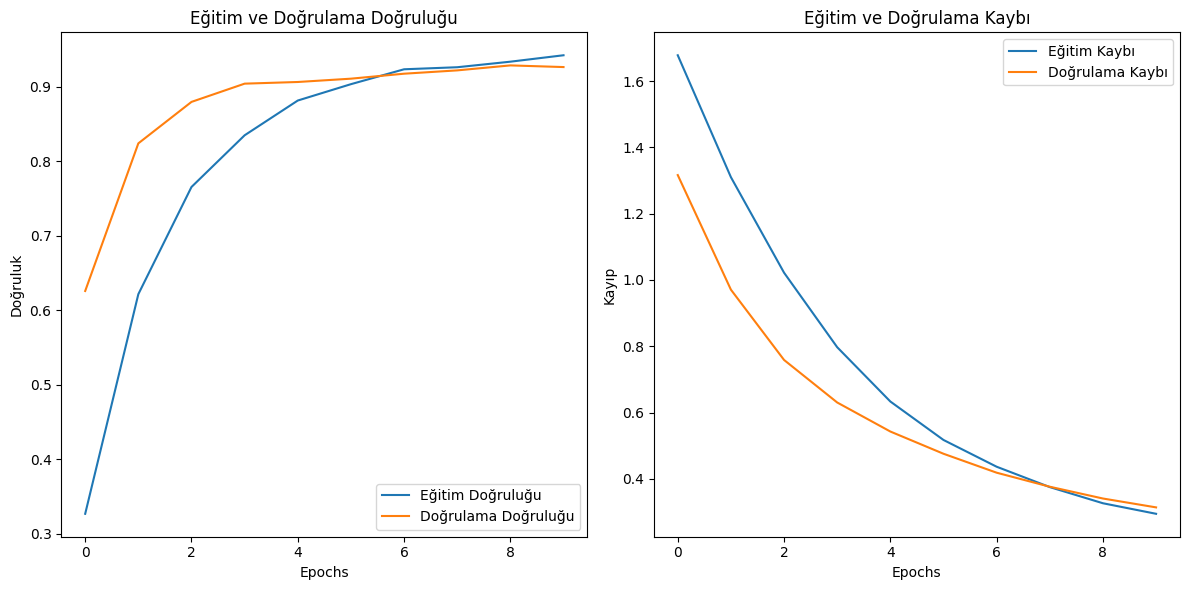

In [ ]:
model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Çıkış katmanı düzenleme (problemimize uygun olması için sınıf sayısında çıkış)
x = tf.keras.layers.GlobalAveragePooling2D()(model.output)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = tf.keras.models.Model(model.input, output)
model.compile(optimizer=Adagrad(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy (Xception):", test_accuracy)

# Predict aşaması
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

# precision, recall ve f1 score değerlerini hesaplama ve yazdırma
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Genel Precision:", precision)
print("Genel Recall:", recall)
print("Genel F1 Score:", f1)

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d", xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Confusion Matrix (Xception)')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Eğitim ve Doğrulama Doğruluğu')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Eğitim ve Doğrulama Kaybı')

plt.tight_layout()
plt.show()

In [ ]:
# .keras formatında yeni bir dosya ismiyle kaydediyoruz
model.save('/content/drive/MyDrive/proje/cicekler/cicekegitim.keras')
print("Model başarıyla .keras formatında kaydedildi.")

Model başarıyla .keras formatında kaydedildi.


In [21]:
import tensorflow as tf

# Modeli .keras dosyasından yükle
model = tf.keras.models.load_model('/content/drive/MyDrive/proje/cicekler/cicekegitim.keras')
print("Model başarıyla yüklendi.")

Model başarıyla yüklendi.


In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Tahmin yapılacak klasör
img_dir = '/content/drive/MyDrive/proje/Test resimleri'

# Sınıf isimlerini elde et
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

# Görselleri yükle, tahmin yap ve göster
image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Her satıra kaç görsel düşsün?
cols = 3
rows = int(np.ceil(len(image_files) / cols))

plt.figure(figsize=(15, rows * 5))

for i, img_name in enumerate(image_files):
    img_path = os.path.join(img_dir, img_name)

    # Görseli yükle
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Tahmin yap
    prediction = model.predict(img_array)
    pred_index = np.argmax(prediction, axis=1)[0]
    pred_label = inv_class_indices[pred_index]
    confidence = round(prediction[0][pred_index] * 100, 2)

    # Görseli çiz
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{img_name}\nTahmin: {pred_label} ({confidence}%)", fontsize=12)

plt.tight_layout()
plt.suptitle("Toplu Görsel Tahmin Sonuçları", fontsize=18, y=1.02)
plt.show()

Output hidden; open in https://colab.research.google.com to view.